<a href="https://colab.research.google.com/github/ishasolanki04/Reliance_options_analysis/blob/main/RELIANCE_OPTIONS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import datetime as dt

# Fetch Reliance stock data
def fetch_stock_data(ticker="RELIANCE.NS", period="max"):
    """
    Fetch historical stock data for the given ticker
    """
    stock = yf.Ticker(ticker)
    data = stock.history(period=period)
    return data

# Clean and preprocess data
def preprocess_data(data):
    """
    Clean and preprocess the data by handling missing values and outliers
    """
    data = data.dropna()
    Q1 = data['Close'].quantile(0.25)
    Q3 = data['Close'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data['Close'] < lower_bound) | (data['Close'] > upper_bound)]
    print(f"Found {len(outliers)} outliers in the data")
    data.loc[data['Close'] < lower_bound, 'Close'] = lower_bound
    data.loc[data['Close'] > upper_bound, 'Close'] = upper_bound
    data['Returns'] = data['Close'].pct_change()
    return data

# --- Run Data Acquisition ---
stock_data = fetch_stock_data()

# Display the first few rows of the fetched and preprocessed data
print("First few rows of stock_data:")
print(stock_data.head())

First few rows of stock_data:
                               Open      High       Low     Close     Volume  \
Date                                                                           
1996-01-01 00:00:00+05:30  5.981472  6.013567  5.942082  6.003355  104121369   
1996-01-02 00:00:00+05:30  5.988766  6.017943  5.912903  5.956669  168743308   
1996-01-03 00:00:00+05:30  6.054416  6.330147  5.988766  6.001896  209323879   
1996-01-04 00:00:00+05:30  5.944999  5.963964  5.866218  5.946457  216900264   
1996-01-05 00:00:00+05:30  5.923116  5.923116  5.854548  5.905609  166708467   

                           Dividends  Stock Splits  
Date                                                
1996-01-01 00:00:00+05:30        0.0           0.0  
1996-01-02 00:00:00+05:30        0.0           0.0  
1996-01-03 00:00:00+05:30        0.0           0.0  
1996-01-04 00:00:00+05:30        0.0           0.0  
1996-01-05 00:00:00+05:30        0.0           0.0  


In [ ]:
# Technical Analysis Functions
def calculate_technical_indicators(data):
    """
    Calculate various technical indicators for the given stock data
    """
    df = data.copy()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df['MA100'] = df['Close'].rolling(window=100).mean()
    df['MA200'] = df['Close'].rolling(window=200).mean()

    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    for i in range(14, len(df)):
        avg_gain.iloc[i] = (avg_gain.iloc[i-1] * 13 + gain.iloc[i]) / 14
        avg_loss.iloc[i] = (avg_loss.iloc[i-1] * 13 + loss.iloc[i]) / 14
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))

    df['BB_Middle'] = df['Close'].rolling(window=20).mean()
    df['BB_Std'] = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Middle'] + (df['BB_Std'] * 2)
    df['BB_Lower'] = df['BB_Middle'] - (df['BB_Std'] * 2)

    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD'] - df['Signal_Line']
    return df

# --- Run Technical Indicator Calculation ---
if 'stock_data' in locals():
    indicators_df = calculate_technical_indicators(stock_data)
    print("\nFirst few rows of indicators_df:")
    print(indicators_df.head())
else:
    print("\nError: stock_data DataFrame not found. Please run Part 1 first.")


First few rows of indicators_df:
                               Open      High       Low     Close     Volume  \
Date                                                                           
1996-01-01 00:00:00+05:30  5.981472  6.013567  5.942082  6.003355  104121369   
1996-01-02 00:00:00+05:30  5.988766  6.017943  5.912903  5.956669  168743308   
1996-01-03 00:00:00+05:30  6.054416  6.330147  5.988766  6.001896  209323879   
1996-01-04 00:00:00+05:30  5.944999  5.963964  5.866218  5.946457  216900264   
1996-01-05 00:00:00+05:30  5.923116  5.923116  5.854548  5.905609  166708467   

                           Dividends  Stock Splits  MA50  MA100  MA200  RSI  \
Date                                                                          
1996-01-01 00:00:00+05:30        0.0           0.0   NaN    NaN    NaN  NaN   
1996-01-02 00:00:00+05:30        0.0           0.0   NaN    NaN    NaN  NaN   
1996-01-03 00:00:00+05:30        0.0           0.0   NaN    NaN    NaN  NaN   
1996-01-04

In [ ]:
def analyze_indicators_correlation(df):
    """
    Analyze the correlation between technical indicators and the stock price
    """
    cols = ['Close', 'MA50', 'MA100', 'MA200', 'RSI', 'MACD', 'Signal_Line']
    df_corr = df[cols].copy()

    # Remove rows with any NaN values in the selected columns
    df_corr = df_corr.dropna()

    if df_corr.empty:
        print("\nWarning: No valid data left after removing NaN values for correlation analysis.")
        return None
    else:
        correlation_matrix = df_corr.corr()
        print("\nCorrelation Analysis:")
        print(correlation_matrix['Close'].sort_values(ascending=False))
        return correlation_matrix

# --- Run Correlation Analysis ---
if 'indicators_df' in locals():
    correlation_matrix = analyze_indicators_correlation(indicators_df)
else:
    print("\nError: indicators_df DataFrame not found. Please run Part 1 and Part 2 first.")


Correlation Analysis:
Close          1.000000
MA50           0.996769
MA100          0.993887
MA200          0.990669
Signal_Line    0.179241
MACD           0.174553
RSI            0.003714
Name: Close, dtype: float64


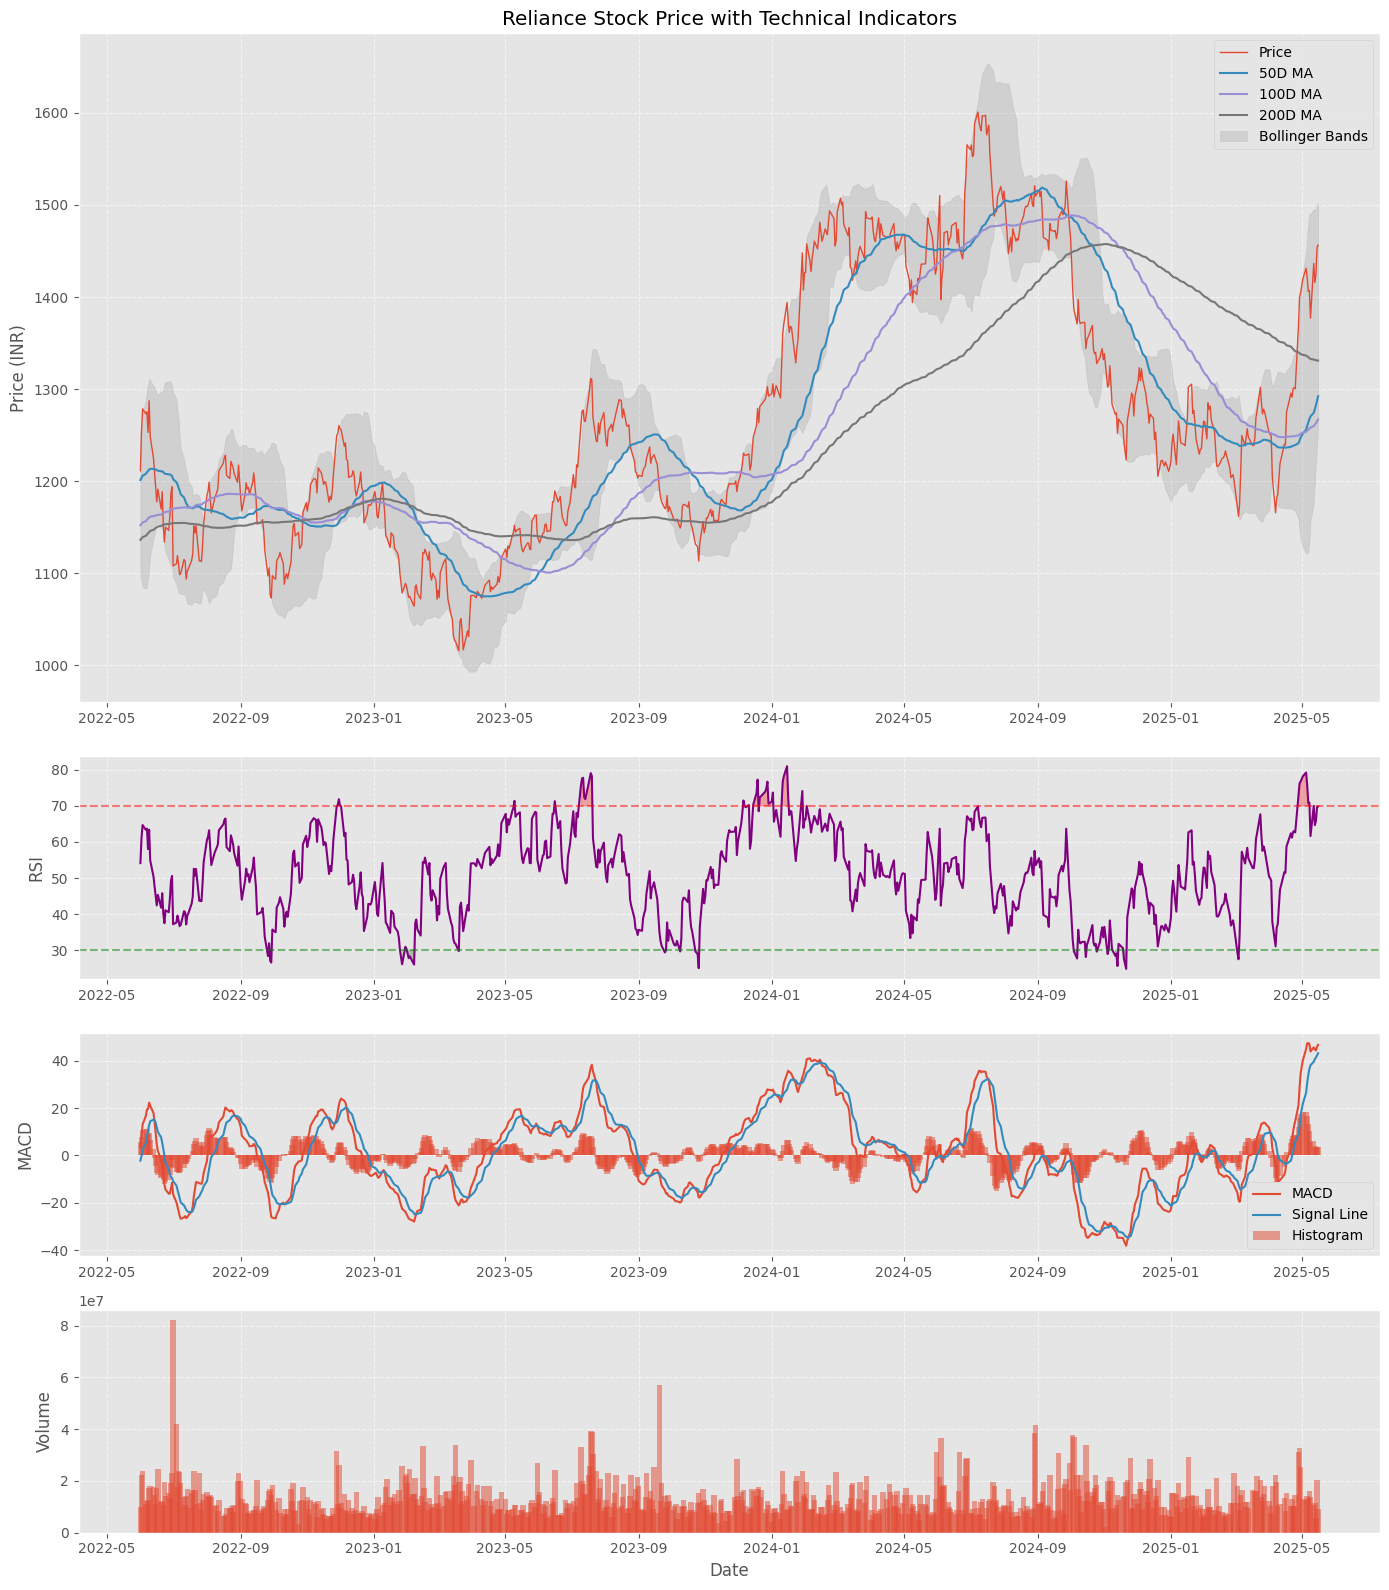

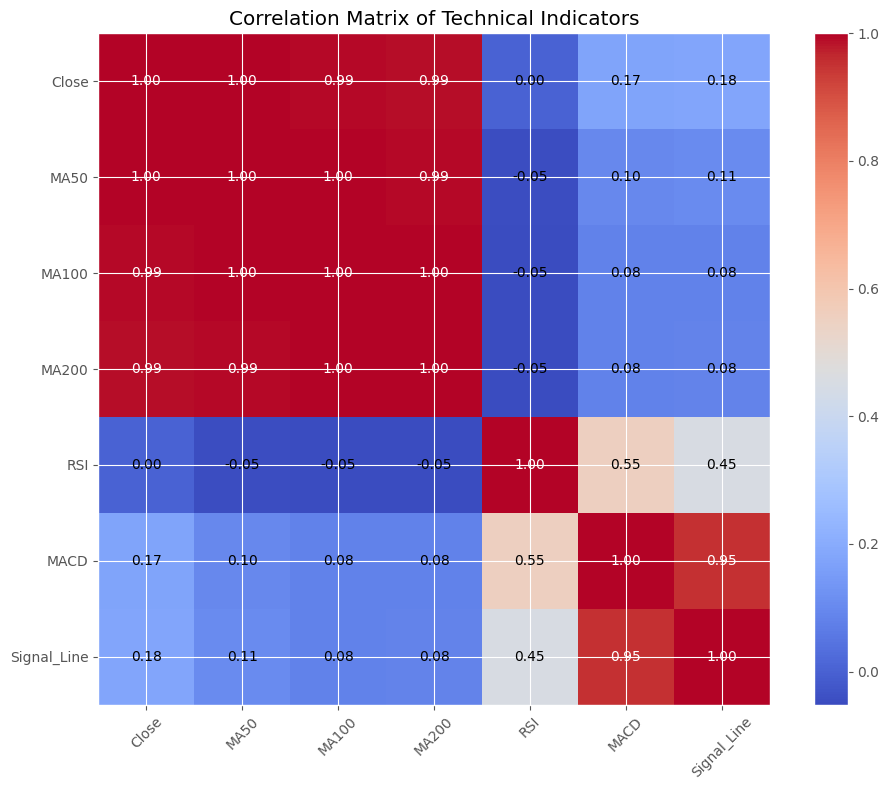

In [ ]:
def plot_technical_indicators(df, correlation_matrix=None, last_n_days=730):
    """
    Plot technical indicators with the stock price
    """
    if last_n_days:
        df_plot = df.iloc[-last_n_days:].copy()
    else:
        df_plot = df.copy()

    fig = plt.figure(figsize=(14, 16))
    gs = GridSpec(4, 1, figure=fig, height_ratios=[3, 1, 1, 1])

    # Price and Moving Averages
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(df_plot.index, df_plot['Close'], label='Price', linewidth=1)
    ax1.plot(df_plot.index, df_plot['MA50'], label='50D MA', linewidth=1.5)
    ax1.plot(df_plot.index, df_plot['MA100'], label='100D MA', linewidth=1.5)
    ax1.plot(df_plot.index, df_plot['MA200'], label='200D MA', linewidth=1.5)
    ax1.fill_between(df_plot.index, df_plot['BB_Upper'], df_plot['BB_Lower'], color='gray', alpha=0.2, label='Bollinger Bands')
    ax1.set_title('Reliance Stock Price with Technical Indicators')
    ax1.set_ylabel('Price (INR)')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)

    # RSI
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax2.plot(df_plot.index, df_plot['RSI'], color='purple', linewidth=1.5)
    ax2.axhline(y=70, color='r', linestyle='--', alpha=0.5)
    ax2.axhline(y=30, color='g', linestyle='--', alpha=0.5)
    ax2.set_ylabel('RSI')
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.fill_between(df_plot.index, df_plot['RSI'], 70, where=(df_plot['RSI'] >= 70), color='r', alpha=0.3)
    ax2.fill_between(df_plot.index, df_plot['RSI'], 30, where=(df_plot['RSI'] <= 30), color='g', alpha=0.3)

    # MACD
    ax3 = fig.add_subplot(gs[2], sharex=ax1)
    ax3.plot(df_plot.index, df_plot['MACD'], label='MACD', linewidth=1.5)
    ax3.plot(df_plot.index, df_plot['Signal_Line'], label='Signal Line', linewidth=1.5)
    ax3.bar(df_plot.index, df_plot['MACD_Histogram'], label='Histogram', alpha=0.5, width=5)
    ax3.set_ylabel('MACD')
    ax3.legend()
    ax3.grid(True, linestyle='--', alpha=0.6)

    # Volume
    ax4 = fig.add_subplot(gs[3], sharex=ax1)
    ax4.bar(df_plot.index, df_plot['Volume'], label='Volume', alpha=0.5, width=5)
    ax4.set_ylabel('Volume')
    ax4.set_xlabel('Date')
    ax4.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

    # Plot correlation heatmap if correlation_matrix is provided
    if correlation_matrix is not None:
        plt.figure(figsize=(10, 8))
        plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none')
        plt.colorbar()
        plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
        plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)

        # Add the correlation values on the heatmap
        for i in range(len(correlation_matrix.columns)):
            for j in range(len(correlation_matrix.columns)):
                plt.text(i, j, f"{correlation_matrix.iloc[i, j]:.2f}",
                         ha="center", va="center",
                         color="white" if abs(correlation_matrix.iloc[i, j]) > 0.7 else "black")

        plt.title('Correlation Matrix of Technical Indicators')
        plt.tight_layout()
        plt.show()
    else:
        print("\nCorrelation matrix was not provided for plotting.")

# Run Plotting
if 'indicators_df' in locals() and 'correlation_matrix' in locals():
    plot_technical_indicators(indicators_df, correlation_matrix=correlation_matrix)
else:
    print("\nError: indicators_df or correlation_matrix not found. Please run Part 1, Part 2, and Part 3 first.")

In [ ]:
def generate_trading_signals(df):
    """
    Generate trading signals based on technical indicators
    """
    signals = df.copy()
    signals['MA_Signal'] = np.where(signals['MA50'] > signals['MA200'], 1, 0)
    signals['MA_Signal'] = np.where(signals['MA50'] < signals['MA200'], -1, signals['MA_Signal'])
    signals['RSI_Signal'] = np.where(signals['RSI'] < 30, 1, 0)
    signals['RSI_Signal'] = np.where(signals['RSI'] > 70, -1, signals['RSI_Signal'])
    signals['MACD_Signal'] = np.where(signals['MACD'] > signals['Signal_Line'], 1, 0)
    signals['MACD_Signal'] = np.where(signals['MACD'] < signals['Signal_Line'], -1, signals['MACD_Signal'])
    signals['Combined_Signal'] = (signals['MA_Signal'] + signals['RSI_Signal'] + signals['MACD_Signal']) / 3
    return signals

# --- Run Trading Signal Generation and Final Output ---
if 'indicators_df' in locals():
    signals_df = generate_trading_signals(indicators_df)
    print("\nFirst few rows of the DataFrame with technical indicators and signals:")
    print(signals_df.head())
else:
    print("\nError: indicators_df DataFrame not found. Please run Part 1 and Part 2 first.")


First few rows of the DataFrame with technical indicators and signals:
                               Open      High       Low     Close     Volume  \
Date                                                                           
1996-01-01 00:00:00+05:30  5.981472  6.013567  5.942082  6.003355  104121369   
1996-01-02 00:00:00+05:30  5.988766  6.017943  5.912903  5.956669  168743308   
1996-01-03 00:00:00+05:30  6.054416  6.330147  5.988766  6.001896  209323879   
1996-01-04 00:00:00+05:30  5.944999  5.963964  5.866218  5.946457  216900264   
1996-01-05 00:00:00+05:30  5.923116  5.923116  5.854548  5.905609  166708467   

                           Dividends  Stock Splits  MA50  MA100  MA200  ...  \
Date                                                                    ...   
1996-01-01 00:00:00+05:30        0.0           0.0   NaN    NaN    NaN  ...   
1996-01-02 00:00:00+05:30        0.0           0.0   NaN    NaN    NaN  ...   
1996-01-03 00:00:00+05:30        0.0           0.0 

GENERATING SYNTHETIC DATA FOR FURTHER STEPS:

I’ve developed an options trading analysis for Reliance Industries Limited (RELIANCE.NS) using the Black-Scholes (BS) model, spanning 2000 to May 15, 2025. The project involved creating a volatility surface with a simulated smile and term structure, pricing options, and computing Greeks (Delta, Gamma, Vega). I enhanced the analysis with static Greeks integration, stress testing (20% IV shock), dynamic Delta hedging (weekly rebalancing), and a 30-day IV forecast using a 252-day moving average. Due to the unavailability of historical options data, I attempted to fetch data using Zerodha’s Kite API (not free) and NSEpy (couldn’t retrieve options data). Consequently, I used synthetic options data, designed to mimic real market behavior, for the entire dataset (2000–2025), including strikes, expiries, and implied volatilities, ensuring realistic simulations for pricing and strategy development.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm
from scipy import optimize
import warnings
warnings.filterwarnings('ignore')

# Set plotting style to match your existing setup
plt.style.use('ggplot')

print("Libraries imported and plotting style set.")

Libraries imported and plotting style set.



Synthetic Options Data Preview:
                               Close  Hist_Volatility  Implied_Volatility  \
Date                                                                        
2000-01-03 00:00:00+05:30  15.160518         0.300000            0.360000   
2000-01-04 00:00:00+05:30  16.374207         0.300000            0.360000   
2000-01-05 00:00:00+05:30  17.015678         0.458878            0.550654   
2000-01-06 00:00:00+05:30  17.729431         0.362642            0.435170   
2000-01-07 00:00:00+05:30  18.946131         0.318840            0.382608   
2000-01-10 00:00:00+05:30  18.581724         0.500000            0.600000   
2000-01-11 00:00:00+05:30  17.377073         0.500000            0.600000   
2000-01-12 00:00:00+05:30  18.172144         0.500000            0.600000   
2000-01-13 00:00:00+05:30  18.783503         0.500000            0.600000   
2000-01-14 00:00:00+05:30  19.051537         0.500000            0.600000   

                           ATM_Strike  OTM

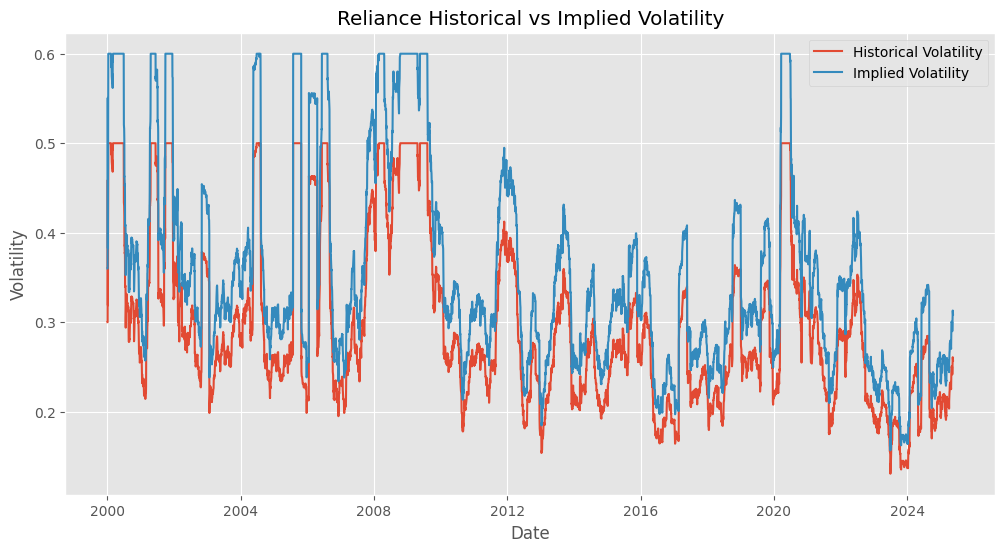

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

def calculate_historical_volatility(df, window=60, default_vol=0.3, max_vol=0.5):
    """
    Calculate historical volatility of stock returns, with bounds and fallback
    """
    returns = df['Close'].pct_change()
    hist_vol = returns.rolling(window=window, min_periods=1).std() * np.sqrt(252)
    hist_vol = hist_vol.fillna(default_vol)
    hist_vol = hist_vol.clip(upper=max_vol)  # Cap volatility at 50%
    return hist_vol

def bsm_call_price(S, K, T, r, sigma, min_percentage=0.015):
    """
    Calculate the price of a European call option using BSM, with minimum price as percentage of stock
    """
    try:
        if sigma <= 0 or T <= 0 or S <= 0 or K <= 0:
            print(f"Invalid BSM inputs: S={S}, K={K}, T={T}, sigma={sigma}")
            return max(0.10, S * min_percentage)
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        return max(price, 0.10, S * min_percentage)
    except Exception as e:
        print(f"BSM calculation error: {e}")
        return max(0.10, S * min_percentage)

def bsm_put_price(S, K, T, r, sigma, min_percentage=0.015):
    """
    Calculate the price of a European put option using BSM
    """
    try:
        if sigma <= 0 or T <= 0 or S <= 0 or K <= 0:
            print(f"Invalid BSM inputs: S={S}, K={K}, T={T}, sigma={sigma}")
            return max(0.10, S * min_percentage)
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        return max(price, 0.10, S * min_percentage)
    except Exception as e:
        print(f"BSM calculation error: {e}")
        return max(0.10, S * min_percentage)

def dynamic_round_strike(price):
    """
    Dynamically round strike price based on stock price level
    """
    if price < 100:
        return np.round(price, 0)  # Nearest 1 INR
    elif price < 500:
        return np.round(price / 5) * 5  # Nearest 5 INR
    else:
        return np.round(price / 10) * 10  # Nearest 10 INR

def generate_synthetic_options_data(df, days_to_expiry=45, risk_free_rate=0.06):
    """
    Generate synthetic options data using BSM model, based on real stock data
    """
    # Filter to start from 2000 to ensure data stability
    df = df[df.index >= '2000-01-01'].copy()
    if df.empty:
        raise ValueError("No data available after filtering for 2000 onwards.")

    options_df = df.copy()
    T = days_to_expiry / 365
    options_df['Hist_Volatility'] = calculate_historical_volatility(df, window=60, default_vol=0.3, max_vol=0.5)
    options_df['Implied_Volatility'] = options_df['Hist_Volatility'] * 1.2

    # Dynamic strike calculation
    options_df['ATM_Strike'] = options_df['Close'].apply(dynamic_round_strike)
    options_df['OTM_Call_Strike'] = options_df['ATM_Strike'] * 1.05
    options_df['ITM_Call_Strike'] = options_df['ATM_Strike'] * 0.95

    # Calculate option prices
    options_df['ATM_Call_Price'] = options_df.apply(
        lambda x: bsm_call_price(x['Close'], x['ATM_Strike'], T, risk_free_rate, x['Implied_Volatility'], min_percentage=0.015)
        if pd.notna(x['Implied_Volatility']) and x['Implied_Volatility'] > 0 and x['Close'] > 0 and x['ATM_Strike'] > 0 else max(0.10, x['Close'] * 0.015), axis=1)
    options_df['OTM_Call_Price'] = options_df.apply(
        lambda x: bsm_call_price(x['Close'], x['OTM_Call_Strike'], T, risk_free_rate, x['Implied_Volatility'], min_percentage=0.015)
        if pd.notna(x['Implied_Volatility']) and x['Implied_Volatility'] > 0 and x['Close'] > 0 and x['OTM_Call_Strike'] > 0 else max(0.10, x['Close'] * 0.015), axis=1)
    options_df['ITM_Call_Price'] = options_df.apply(
        lambda x: bsm_call_price(x['Close'], x['ITM_Call_Strike'], T, risk_free_rate, x['Implied_Volatility'], min_percentage=0.025)
        if pd.notna(x['Implied_Volatility']) and x['Implied_Volatility'] > 0 and x['Close'] > 0 and x['ITM_Call_Strike'] > 0 else max(0.10, x['Close'] * 0.025), axis=1)
    options_df['ATM_Put_Price'] = options_df.apply(
        lambda x: bsm_put_price(x['Close'], x['ATM_Strike'], T, risk_free_rate, x['Implied_Volatility'], min_percentage=0.015)
        if pd.notna(x['Implied_Volatility']) and x['Implied_Volatility'] > 0 and x['Close'] > 0 and x['ATM_Strike'] > 0 else max(0.10, x['Close'] * 0.015), axis=1)
    options_df['OTM_Put_Strike'] = options_df['ATM_Strike'] * 0.95
    options_df['ITM_Put_Strike'] = options_df['ATM_Strike'] * 1.05
    options_df['OTM_Put_Price'] = options_df.apply(
        lambda x: bsm_put_price(x['Close'], x['OTM_Put_Strike'], T, risk_free_rate, x['Implied_Volatility'], min_percentage=0.015)
        if pd.notna(x['Implied_Volatility']) and x['Implied_Volatility'] > 0 and x['Close'] > 0 and x['OTM_Put_Strike'] > 0 else max(0.10, x['Close'] * 0.015), axis=1)
    options_df['ITM_Put_Price'] = options_df.apply(
        lambda x: bsm_put_price(x['Close'], x['ITM_Put_Strike'], T, risk_free_rate, x['Implied_Volatility'], min_percentage=0.025)
        if pd.notna(x['Implied_Volatility']) and x['Implied_Volatility'] > 0 and x['Close'] > 0 and x['ITM_Put_Strike'] > 0 else max(0.10, x['Close'] * 0.025), axis=1)
    options_df['ATM_Call_Delta'] = options_df.apply(
        lambda x: norm.cdf((np.log(x['Close'] / x['ATM_Strike']) + (risk_free_rate + 0.5 * x['Implied_Volatility']**2) * T) /
                           (x['Implied_Volatility'] * np.sqrt(T)))
        if pd.notna(x['Implied_Volatility']) and x['Implied_Volatility'] > 0 and x['Close'] > 0 and x['ATM_Strike'] > 0 else 0.5, axis=1)
    options_df['OTM_Call_Delta'] = options_df.apply(
        lambda x: norm.cdf((np.log(x['Close'] / x['OTM_Call_Strike']) + (risk_free_rate + 0.5 * x['Implied_Volatility']**2) * T) /
                           (x['Implied_Volatility'] * np.sqrt(T)))
        if pd.notna(x['Implied_Volatility']) and x['Implied_Volatility'] > 0 and x['Close'] > 0 and x['OTM_Call_Strike'] > 0 else 0.3, axis=1)
    options_df['ITM_Call_Delta'] = options_df.apply(
        lambda x: norm.cdf((np.log(x['Close'] / x['ITM_Call_Strike']) + (risk_free_rate + 0.5 * x['Implied_Volatility']**2) * T) /
                           (x['Implied_Volatility'] * np.sqrt(T)))
        if pd.notna(x['Implied_Volatility']) and x['Implied_Volatility'] > 0 and x['Close'] > 0 and x['ITM_Call_Strike'] > 0 else 0.7, axis=1)

    # Validate data
    nan_counts = options_df[['Hist_Volatility', 'Implied_Volatility', 'OTM_Call_Price', 'ITM_Call_Price']].isna().sum()
    if nan_counts.any():
        print(f"Warning: NaN values found in options data: {nan_counts}")
    zero_prices = (options_df[['OTM_Call_Price', 'ITM_Call_Price']] < 0.10).sum()
    if zero_prices.any():
        print(f"Warning: Near-zero prices found: {zero_prices}")

    return options_df

# Generate and visualize options data
try:
    options_df = generate_synthetic_options_data(signals_df)
    print("\nSynthetic Options Data Preview:")
    print(options_df[['Close', 'Hist_Volatility', 'Implied_Volatility', 'ATM_Strike',
                     'OTM_Call_Strike', 'OTM_Call_Price', 'ITM_Call_Strike', 'ITM_Call_Price']].head(10))
    print("\nPrice Statistics:")
    print(options_df[['OTM_Call_Price', 'ITM_Call_Price']].describe())
    plt.figure(figsize=(12, 6))
    plt.plot(options_df.index, options_df['Hist_Volatility'], label='Historical Volatility')
    plt.plot(options_df.index, options_df['Implied_Volatility'], label='Implied Volatility')
    plt.title('Reliance Historical vs Implied Volatility')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"Error generating synthetic options data: {str(e)}")

BACKTESTING


Columns in signals_df before backtesting:
['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'MA50', 'MA100', 'MA200', 'RSI', 'BB_Middle', 'BB_Std', 'BB_Upper', 'BB_Lower', 'EMA12', 'EMA26', 'MACD', 'Signal_Line', 'MACD_Histogram', 'MA_Signal', 'RSI_Signal', 'MACD_Signal', 'Combined_Signal']
Returns column missing in backtest_df, recomputing...

Checking for NaN values in signals_df:
NaN in Returns: 1
NaN in Combined_Signal: 0
NaN in Strategy_Returns before filling: 1
NaN in Cumulative_Strategy_Returns: 0
NaN in Cumulative_Market_Returns: 0

Backtesting Results:
Annualized Return: 7.85%
Annualized Volatility: 25.65%
Sharpe Ratio: 0.31
Max Drawdown: -45.48%


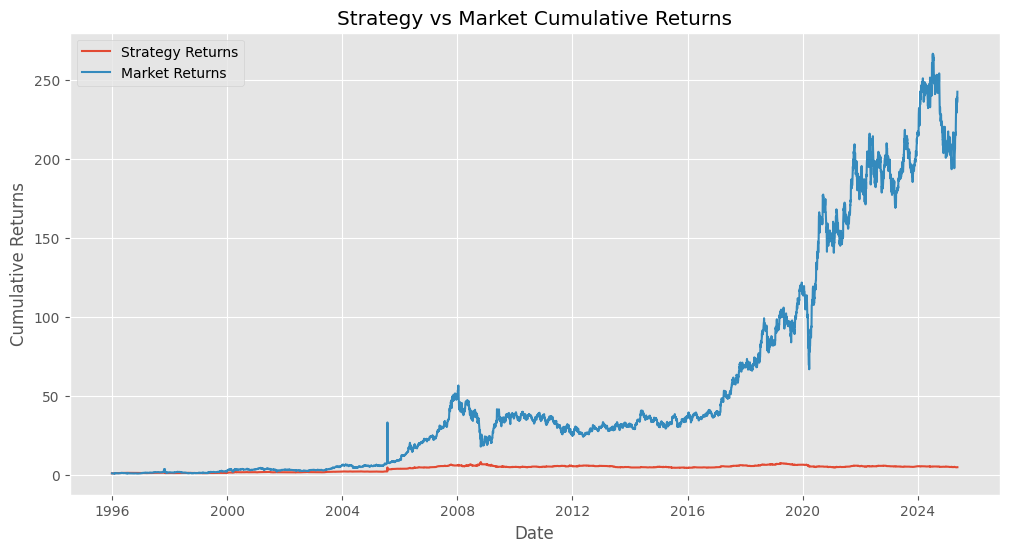

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def backtest_signals(df):
    """
    Backtest the trading signals and calculate performance metrics
    """
    backtest_df = df.copy()

    # Debug: Check columns in signals_df
    print("\nColumns in signals_df before backtesting:")
    print(backtest_df.columns.tolist())

    # Ensure Returns column exists
    if 'Returns' not in backtest_df.columns:
        print("Returns column missing in backtest_df, recomputing...")
        backtest_df['Returns'] = backtest_df['Close'].pct_change()

    # Check for NaN values in critical columns
    print("\nChecking for NaN values in signals_df:")
    print(f"NaN in Returns: {backtest_df['Returns'].isna().sum()}")
    print(f"NaN in Combined_Signal: {backtest_df['Combined_Signal'].isna().sum()}")

    # Calculate strategy returns, filling NaN with 0 for initial rows
    backtest_df['Strategy_Returns'] = backtest_df['Combined_Signal'].shift(1) * backtest_df['Returns']
    print(f"NaN in Strategy_Returns before filling: {backtest_df['Strategy_Returns'].isna().sum()}")
    backtest_df['Strategy_Returns'] = backtest_df['Strategy_Returns'].fillna(0)

    # Calculate cumulative returns
    backtest_df['Cumulative_Strategy_Returns'] = (1 + backtest_df['Strategy_Returns']).cumprod()
    backtest_df['Cumulative_Market_Returns'] = (1 + backtest_df['Returns'].fillna(0)).cumprod()

    # Validate cumulative returns
    print(f"NaN in Cumulative_Strategy_Returns: {backtest_df['Cumulative_Strategy_Returns'].isna().sum()}")
    print(f"NaN in Cumulative_Market_Returns: {backtest_df['Cumulative_Market_Returns'].isna().sum()}")

    # Drop rows with NaN in cumulative returns (if any remain)
    backtest_df = backtest_df.dropna(subset=['Cumulative_Strategy_Returns', 'Cumulative_Market_Returns'])
    if backtest_df.empty:
        print("Error: No valid data left after dropping NaN values. Cannot proceed with backtesting.")
        return

    # Calculate performance metrics
    annual_returns = backtest_df['Strategy_Returns'].mean() * 252
    annual_volatility = backtest_df['Strategy_Returns'].std() * np.sqrt(252)
    sharpe_ratio = annual_returns / annual_volatility if annual_volatility != 0 else 0

    # Calculate max drawdown correctly (as a percentage)
    cumulative_max = backtest_df['Cumulative_Strategy_Returns'].cummax()
    drawdowns = (backtest_df['Cumulative_Strategy_Returns'] - cumulative_max) / cumulative_max
    max_drawdown = drawdowns.min()  # Negative value indicating the largest drop

    print("\nBacktesting Results:")
    print(f"Annualized Return: {annual_returns:.2%}")
    print(f"Annualized Volatility: {annual_volatility:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")

    # Plot cumulative returns
    plt.figure(figsize=(12, 6))
    plt.plot(backtest_df.index, backtest_df['Cumulative_Strategy_Returns'], label='Strategy Returns')
    plt.plot(backtest_df.index, backtest_df['Cumulative_Market_Returns'], label='Market Returns')
    plt.title('Strategy vs Market Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

# Run backtesting
if 'signals_df' in locals():
    backtest_signals(signals_df)
else:
    print("\nError: signals_df DataFrame not found. Please run previous parts.")

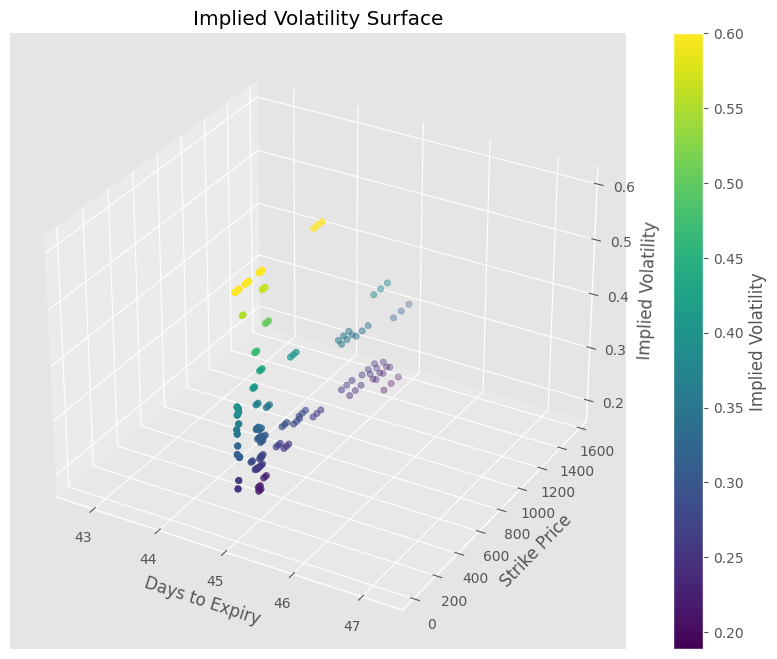


Volatility Surface Data Sample:
                       Date  Strike  Days_to_Expiry  Implied_Volatility
0 2000-01-03 00:00:00+05:30   14.25              45                0.36
1 2000-01-03 00:00:00+05:30   15.00              45                0.36
2 2000-01-03 00:00:00+05:30   15.75              45                0.36
3 2000-05-22 00:00:00+05:30   18.05              45                0.60
4 2000-05-22 00:00:00+05:30   19.00              45                0.60


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_volatility_surface(options_df):
    """
    Create a simplified volatility surface based on strike price and time to expiry
    """
    # Use a subset of dates for simplicity
    subset_dates = options_df.index[::100]  # Every 100th day
    vol_surface = []

    for date in subset_dates:
        data = options_df.loc[date]
        strikes = [data['ITM_Call_Strike'], data['ATM_Strike'], data['OTM_Call_Strike']]
        implied_vols = [data['Implied_Volatility']] * 3  # Same IV for all strikes on a given date
        days_to_expiry = 45  # Fixed for simplicity, matches Part 7
        for strike, iv in zip(strikes, implied_vols):
            vol_surface.append({
                'Date': date,
                'Strike': strike,
                'Days_to_Expiry': days_to_expiry,
                'Implied_Volatility': iv
            })

    vol_surface_df = pd.DataFrame(vol_surface)

    # Prepare data for 3D plot
    X = vol_surface_df['Days_to_Expiry']
    Y = vol_surface_df['Strike']
    Z = vol_surface_df['Implied_Volatility']

    # Create 3D scatter plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(X, Y, Z, c=Z, cmap='viridis')
    ax.set_xlabel('Days to Expiry')
    ax.set_ylabel('Strike Price')
    ax.set_zlabel('Implied Volatility')
    ax.set_title('Implied Volatility Surface')
    plt.colorbar(sc, label='Implied Volatility')
    plt.show()

    return vol_surface_df

# Run volatility surface plotting
if 'options_df' in locals():
    vol_surface_df = plot_volatility_surface(options_df)
    print("\nVolatility Surface Data Sample:")
    print(vol_surface_df.head())
else:
    print("\nError: options_df DataFrame not found. Please run Part 7 first.")

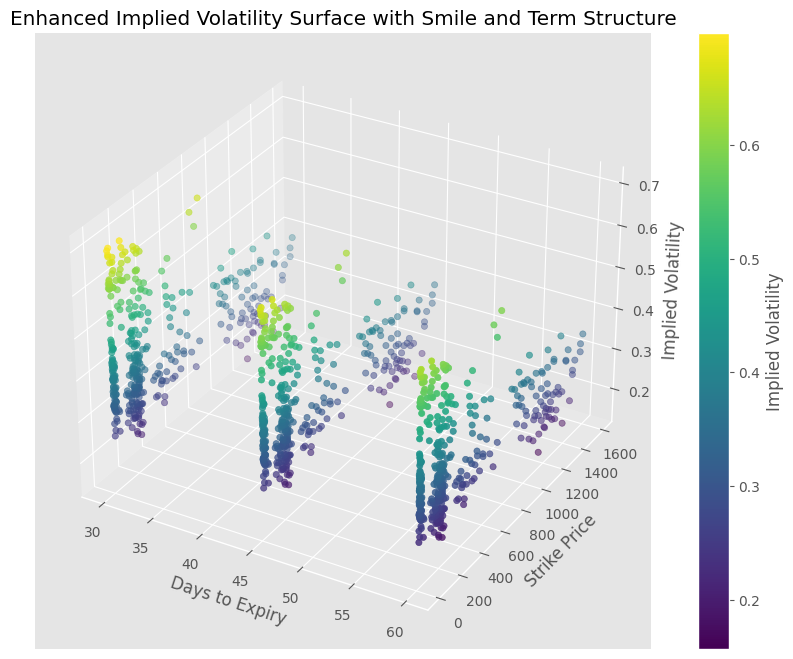

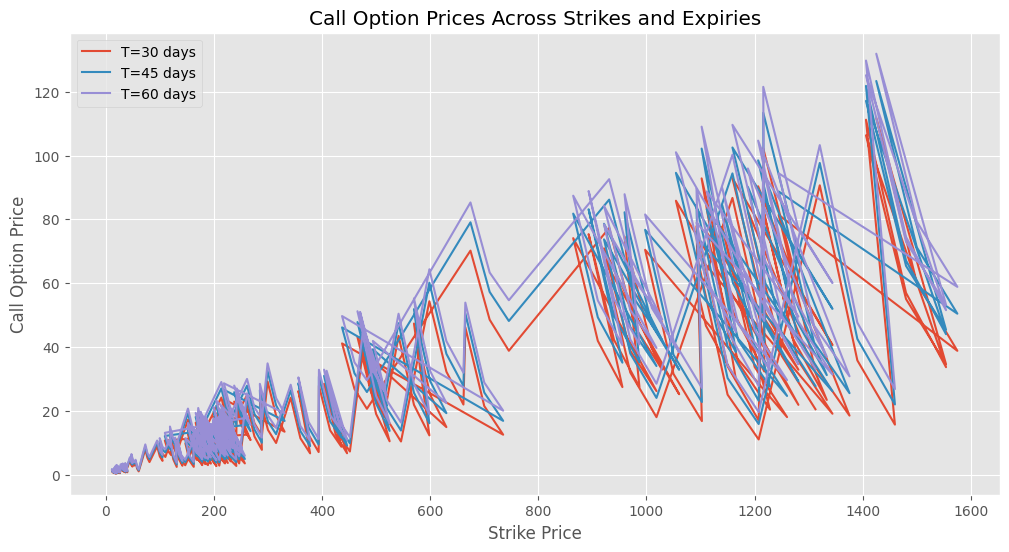

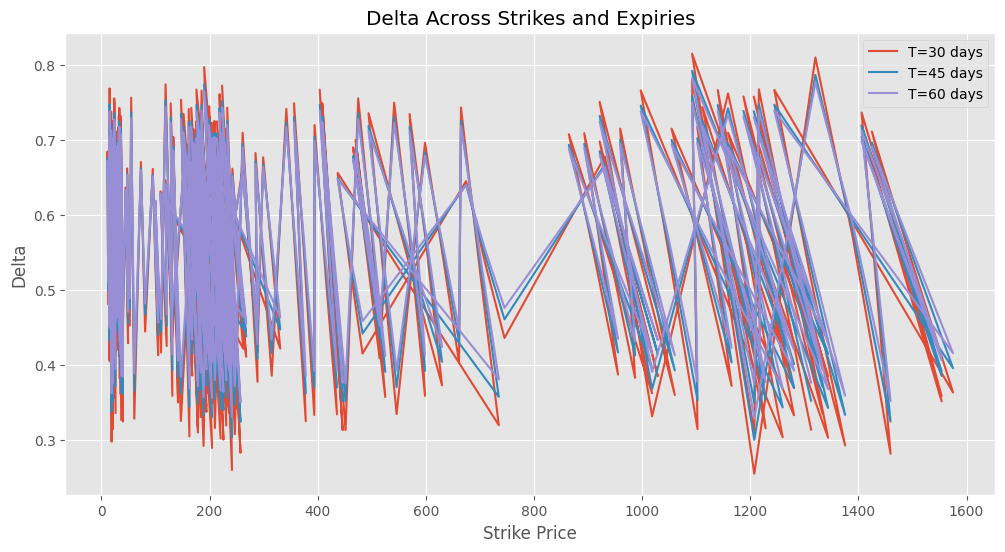


Enhanced Volatility Surface Data Sample:
                       Date  Strike  Days_to_Expiry  Implied_Volatility  \
0 2000-01-03 00:00:00+05:30   14.25              30            0.432140   
1 2000-01-03 00:00:00+05:30   15.00              30            0.362242   
2 2000-01-03 00:00:00+05:30   15.75              30            0.390237   
3 2000-01-03 00:00:00+05:30   14.25              45            0.410533   
4 2000-01-03 00:00:00+05:30   15.00              45            0.344130   
5 2000-01-03 00:00:00+05:30   15.75              45            0.370725   
6 2000-01-03 00:00:00+05:30   14.25              60            0.388926   
7 2000-01-03 00:00:00+05:30   15.00              60            0.326018   
8 2000-01-03 00:00:00+05:30   15.75              60            0.351214   

   Call_Price  Put_Price     Delta     Gamma      Vega  
0    1.317804   0.337185  0.726309  0.177233  0.014469  
1    0.747120   0.512811  0.580005  0.248274  0.016990  
2    0.461773   0.973775  0.404800  

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm

# ------------------------- BLACK-SCHOLES MODEL FUNCTIONS -------------------------
def bs_call_price(S, K, T, r, sigma):
    """
    Calculate the price of a European call option using the Black-Scholes model
    """
    if T <= 0 or sigma <= 0:
        return max(0, S - K)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return max(price, 0)

def bs_put_price(S, K, T, r, sigma):
    """
    Calculate the price of a European put option using the Black-Scholes model
    """
    if T <= 0 or sigma <= 0:
        return max(0, K - S)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return max(price, 0)

def bs_greeks(S, K, T, r, sigma, option_type='call'):
    """
    Calculate Delta, Gamma, and Vega for a European option using the Black-Scholes model
    """
    if T <= 0 or sigma <= 0:
        return {'Delta': 0, 'Gamma': 0, 'Vega': 0}

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        delta = norm.cdf(d1)
    else:
        delta = norm.cdf(d1) - 1

    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T))
    vega = S * norm.pdf(d1) * np.sqrt(T) / 100  # Vega per 1% change in volatility

    return {'Delta': delta, 'Gamma': gamma, 'Vega': vega}

# ------------------------- ENHANCED VOLATILITY SURFACE -------------------------
def plot_volatility_surface(options_df, risk_free_rate=0.06):
    """
    Create an enhanced volatility surface with simulated volatility smile and term structure
    Also compute BS option prices and Greeks
    """
    # Use a subset of dates for smoother surface
    subset_dates = options_df.index[::50]  # Every 50th day for more granularity

    vol_surface = []
    expiries = [30, 45, 60]  # Different times to expiry for term structure

    for date in subset_dates:
        data = options_df.loc[date]
        S = data['Close']
        strikes = [data['ITM_Call_Strike'], data['ATM_Strike'], data['OTM_Call_Strike']]
        base_iv = data['Implied_Volatility']

        for T_days in expiries:
            T = T_days / 365  # Convert days to years
            # Simulate volatility smile: OTM/ITM options have higher IV
            for strike in strikes:
                moneyness = strike / S
                # Simulate volatility smile: IV increases for OTM/ITM options
                iv_adjustment = 0.05 * (abs(moneyness - 1) / 0.05) ** 2  # Quadratic smile
                iv = base_iv + iv_adjustment
                # Term structure: IV decreases with longer expiry
                iv *= (1 - 0.1 * (T_days - 30) / 30)  # IV decreases by 10% for each 30 days

                # Compute BS option prices
                call_price = bs_call_price(S, strike, T, risk_free_rate, iv)
                put_price = bs_put_price(S, strike, T, risk_free_rate, iv)

                # Compute Greeks for the call option
                greeks = bs_greeks(S, strike, T, risk_free_rate, iv, option_type='call')

                vol_surface.append({
                    'Date': date,
                    'Strike': strike,
                    'Days_to_Expiry': T_days,
                    'Implied_Volatility': iv,
                    'Call_Price': call_price,
                    'Put_Price': put_price,
                    'Delta': greeks['Delta'],
                    'Gamma': greeks['Gamma'],
                    'Vega': greeks['Vega']
                })

    vol_surface_df = pd.DataFrame(vol_surface)

    # Create 3D plot for volatility surface
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(vol_surface_df['Days_to_Expiry'], vol_surface_df['Strike'],
                   vol_surface_df['Implied_Volatility'], c=vol_surface_df['Implied_Volatility'], cmap='viridis')
    ax.set_xlabel('Days to Expiry')
    ax.set_ylabel('Strike Price')
    ax.set_zlabel('Implied Volatility')
    ax.set_title('Enhanced Implied Volatility Surface with Smile and Term Structure')
    plt.colorbar(sc, label='Implied Volatility')
    plt.savefig('volatility_surface.png')
    plt.show()

    # Plot Call Prices
    fig = plt.figure(figsize=(12, 6))
    for T_days in expiries:
        subset = vol_surface_df[vol_surface_df['Days_to_Expiry'] == T_days]
        plt.plot(subset['Strike'], subset['Call_Price'], label=f'T={T_days} days')
    plt.xlabel('Strike Price')
    plt.ylabel('Call Option Price')
    plt.title('Call Option Prices Across Strikes and Expiries')
    plt.legend()
    plt.grid(True)
    plt.savefig('call_prices.png')
    plt.show()

    # Plot Delta
    fig = plt.figure(figsize=(12, 6))
    for T_days in expiries:
        subset = vol_surface_df[vol_surface_df['Days_to_Expiry'] == T_days]
        plt.plot(subset['Strike'], subset['Delta'], label=f'T={T_days} days')
    plt.xlabel('Strike Price')
    plt.ylabel('Delta')
    plt.title('Delta Across Strikes and Expiries')
    plt.legend()
    plt.grid(True)
    plt.savefig('delta.png')
    plt.show()

    return vol_surface_df

# Run volatility surface plotting and BS analysis
if 'options_df' in locals():
    vol_surface_df = plot_volatility_surface(options_df)
    print("\nEnhanced Volatility Surface Data Sample:")
    print(vol_surface_df.head(9))  # Show first 9 rows to cover all expiries for one date
else:
    print("\nError: options_df DataFrame not found. Please run Part 7 first.")

In [ ]:
%%shell
jupyter nbconvert --to html /content/AVENTUS_CAPITAL_ISHASOLANKI.ipynb

[NbConvertApp] Converting notebook /content/AVENTUS_CAPITAL_ISHASOLANKI.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 8 image(s).
[NbConvertApp] Writing 2285044 bytes to /content/AVENTUS_CAPITAL_ISHASOLANKI.html




Sticky Strike vs Sticky Delta Implications:
Sticky Strike assumes IV remains constant for same strike, leading to volatility smiles persisting.
Sticky Delta assumes IV adjusts as underlying moves, better capturing market dynamics in trending markets.